In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SECCIÓN 1: SIMULACIÓN DE DATOS DE CLIENTES
# OBJETIVO: Crear datos sintéticos que representen 3 segmentos naturales de clientes
# CONCEPTO: Generamos datos con distribución normal para simular comportamiento real

np.random.seed(42)

# Creación del DataFrame con datos simulados de clientes
datos = pd.DataFrame({
    'Ingreso': np.concatenate([
        # CLUSTER 1: Clientes de bajos ingresos (50 clientes)
        np.random.normal(30000, 5000, 50),  
        # CLUSTER 2: Clientes de ingresos medios (50 clientes)
        np.random.normal(80000, 10000, 50), 
        # CLUSTER 3: Clientes de altos ingresos (50 clientes)
        np.random.normal(150000, 20000, 50)
        ]),
    
    'Gasto': np.concatenate([
        # GASTOS CORRESPONDIENTES A CADA CLUSTER DE INGRESOS
        np.random.normal(500, 200, 50),     # Clientes bajos: gasto ~$500 ± $200
        np.random.normal(5000, 1000, 50),   # Clientes medios: gasto ~$5,000 ± $1,000
        np.random.normal(15000, 3000, 50)   # Clientes altos: gasto ~$15,000 ± $3,000
    ])
})

print("Primeras filas de los datos originales:")
print(datos.head())


Primeras filas de los datos originales:
        Ingreso       Gasto
0  32483.570765  550.098570
1  29308.678494  569.289642
2  33238.442691  363.995056
3  37615.149282  546.450739
4  28829.233126  558.614495


In [2]:
# SECCIÓN 2: ESTANDARIZACIÓN DE DATOS (BALANCEO DE ESCALAS)


# Creación del objeto StandardScaler para estandarización
scaler = StandardScaler()

# Aplicación de la estandarización a los datos
datos_escalados = scaler.fit_transform(datos)

print("Datos escalados (primeras 5 filas):")
print(datos_escalados[:5])


Datos escalados (primeras 5 filas):
[[-1.05168498 -0.99943049]
 [-1.1139741  -0.99639468]
 [-1.03687494 -1.02886991]
 [-0.95100709 -1.00000753]
 [-1.12338047 -0.99808337]]


In [4]:
# SECCIÓN 3: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (MÉTODO DEL CODO)
# OBJETIVO: Encontrar el valor ideal de K donde agregar más clusters no mejora significativamente el modelo

# Inicialización de lista para almacenar los valores de inercia para cada K
inercia = []

# Rango de K a probar: desde 1 hasta 10 clusters
k_range = range(1, 11)


# Bucle para probar cada valor de K en el rango definido
for i in k_range:
    # Creación del modelo KMeans para el valor actual de K
    kmeans = KMeans(
        n_clusters=i,           # Número de clusters a formar
        random_state=42,        # Semilla para reproducibilidad en la inicialización de centroides
        n_init='auto'           # Número de inicializaciones aleatorias (elige automáticamente el óptimo)
    )

    # Entrenamiento del modelo KMeans con los datos estandarizados
    kmeans.fit(datos_escalados)

    # Almacenamiento del valor de inercia para este K
    inercia.append(kmeans.inertia_)

    # Impresión del progreso con formato de 2 decimales
    print(f"K={i}: Inercia = {kmeans.inertia_:.2f}")

# ANÁLISIS CUANTITATIVO DE LA REDUCCIÓN DE INERCIA  

# Creación de DataFrame para análisis estructurado de los resultados
df_inercia = pd.DataFrame({
    'K': list(k_range),        # Columna con valores de K probados (1 a 10)
    'Inercia': inercia         # Columna con los valores de inercia correspondientes
}) 

# Cálculo de la reducción en inercia entre valores consecutivos de K
df_inercia['Reduccion_Inercia'] = df_inercia['Inercia'].diff().fillna(0)

# Cálculo de la reducción relativa (cambio en la pendiente del codo)
df_inercia['Cambio_Reduccion'] = df_inercia['Reduccion_Inercia'].diff().fillna(0)

# Buscamos el punto donde el 'Cambio_Reduccion' es mayor (la pendiente se suaviza más rápido)
# Excluimos K=1 y K=2 que son siempre los puntos de mayor cambio.
if len(df_inercia) > 3:
    mayor_desaceleracion = df_inercia.loc[2:, 'Cambio_Reduccion'].max()
    k_codo = df_inercia.loc[df_inercia['Cambio_Reduccion'] == mayor_desaceleracion, 'K'].values[0]

    print(f"Mayor desaceleración (Punto de Codo): K={k_codo}")
    

K=1: Inercia = 300.00
K=2: Inercia = 62.79
K=3: Inercia = 23.54
K=4: Inercia = 18.34
K=5: Inercia = 13.42
K=6: Inercia = 12.32
K=7: Inercia = 8.76
K=8: Inercia = 7.61
K=9: Inercia = 7.33
K=10: Inercia = 6.16
Mayor desaceleración (Punto de Codo): K=3


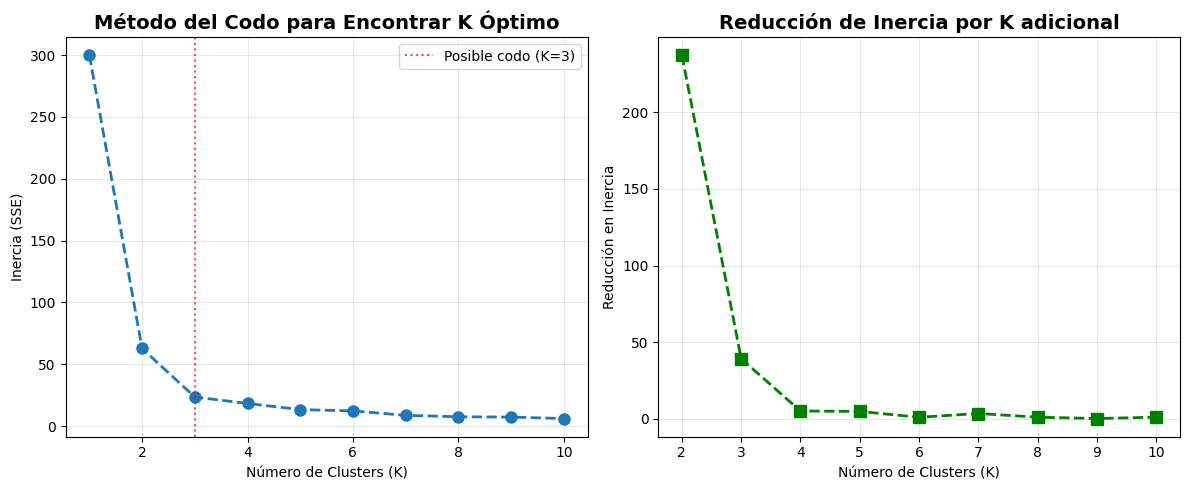

In [5]:
# SECCIÓN 4: VISUALIZACIÓN DEL MÉTODO DEL CODO

# Crear figura con dos subgráficos lado a lado
plt.figure(figsize=(12, 5))

# SUBGRÁFICO 1: GRÁFICO DEL CODO TRADICIONAL
plt.subplot(1, 2, 1)

# Crear el gráfico de línea de inercia vs K
plt.plot(range(1, 11), inercia, 
         marker='o',     
         linestyle='--',    
         linewidth=2,       
         markersize=8) 
plt.title('Método del Codo para Encontrar K Óptimo', fontsize=14, fontweight='bold') 
plt.xlabel('Número de Clusters (K)')  
plt.ylabel('Inercia (SSE)')  
plt.grid(True, alpha=0.3)

# LÍNEA VERTICAL PARA DESTACAR EL CODO SUGERIDO
plt.axvline(x=3,                    # Posición vertical en K=3
            color='red',         
            linestyle=':',        
            alpha=0.7,          
            label='Posible codo (K=3)')
plt.legend()

# SUBGRÁFICO 2: ANÁLISIS DE REDUCCIONES MARGINALES

plt.subplot(1, 2, 2)
# Calcular las reducciones absolutas de inercia
diferencias = [-df_inercia['Reduccion_Inercia'].iloc[i] for i in range(1, len(df_inercia))]

# Crear gráfico de reducciones marginales
plt.plot(range(2, 11), diferencias,  
         marker='s',                
         linestyle='--',          
         linewidth=2,               
         markersize=8,              
         color='green')  

plt.title('Reducción de Inercia por K adicional', 
          fontsize=14, 
          fontweight='bold')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Reducción en Inercia')
plt.grid(True, alpha=0.3)  

plt.tight_layout()
plt.show()

In [6]:
# SECCIÓN 5: APLICACIÓN FINAL DE K-MEANS Y VISUALIZACIÓN DE RESULTADOS
# OBJETIVO: Aplicar el algoritmo K-Means con el K óptimo identificado y visualizar los segmentos

kmeans_final = KMeans(n_clusters=3,      # Número óptimo de clusters identificado
                     random_state=42,    # Semilla para reproducibilidad
                     n_init='auto')      # Inicializaciones automáticas

clusters = kmeans_final.fit_predict(datos_escalados)

# Agregar las etiquetas de cluster al DataFrame original
datos['Cluster'] = clusters

# OBTENCIÓN Y TRANSFORMACIÓN DE CENTROIDES
# Obtener centroides en la escala estandarizada
centroides_escalados = kmeans_final.cluster_centers_

# Transformar centroides a la escala original para interpretación
centroides_original = scaler.inverse_transform(centroides_escalados)

# Crear DataFrame con los centroides para mejor visualización
centroides_df = pd.DataFrame(centroides_original,  
                            columns=['Ingreso', 'Gasto'])  # Nombres de columnas
centroides_df.index = [f'Cluster {i}' for i in range(3)]  # Nombres de filas
print(centroides_df)

                 Ingreso         Gasto
Cluster 0   81570.490969   5153.424804
Cluster 1  149173.629166  15133.617897
Cluster 2   28872.630474    516.779348


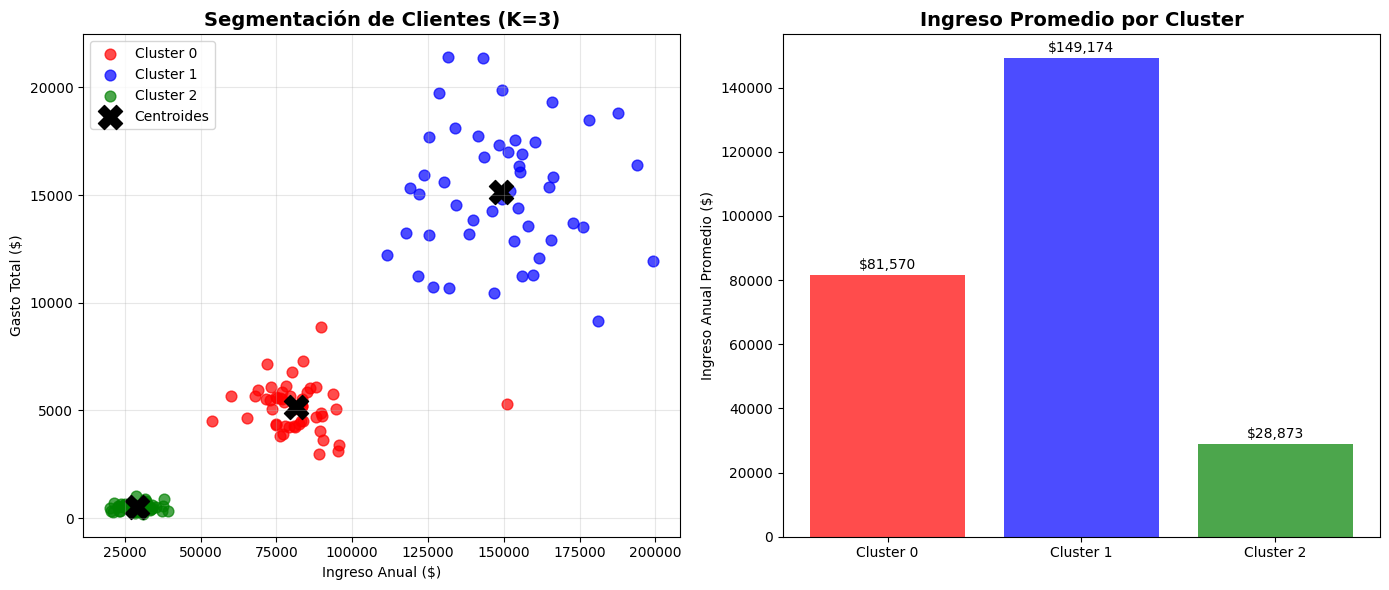

In [7]:
# VISUALIZACIÓN FINAL DE LOS SEGMENTOS
plt.figure(figsize=(14, 6))

# SUBGRÁFICO 1: DIAGRAMA DE DISPERSIÓN CON CLUSTERS

plt.subplot(1, 2, 1)
# Definir colores distintivos para cada cluster
colores = ['red', 'blue', 'green']

for i in range(3):
    # Filtrar datos pertenecientes al cluster actual
    cluster_data = datos[datos['Cluster'] == i]

    # Graficar puntos del cluster actual
    plt.scatter(cluster_data['Ingreso'],  
                cluster_data['Gasto'],     
                c=colores[i],            
                label=f'Cluster {i}',   
                s=60,                 
                alpha=0.7) 
    
# Graficar centroides como marcadores especiales
plt.scatter(centroides_original[:, 0],    
            centroides_original[:, 1],  
            marker='X',                  
            s=300,                    
            color='black',         
            label='Centroides')        

# Configurar el gráfico de dispersión
plt.title('Segmentación de Clientes (K=3)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Ingreso Anual ($)')
plt.ylabel('Gasto Total ($)')
plt.legend()                
plt.grid(True, alpha=0.3)     

# SUBGRÁFICO 2: ANÁLISIS COMPARATIVO DE INGRESOS
plt.subplot(1, 2, 2)
# Calcular estadísticas agregadas por cluster
datos_grouped = datos.groupby('Cluster').agg({
    'Ingreso': ['mean', 'std'],    # Media y desviación estándar de ingreso
    'Gasto': ['mean', 'std'],      # Media y desviación estándar de gasto
    'Cluster': 'count'             # Conteo de clientes por cluster
}).round(2)

# Crear gráfico de barras para ingresos promedio
bars = plt.bar([f'Cluster {i}' for i in range(3)], 
               datos_grouped[('Ingreso', 'mean')],   
               color=colores,                        
               alpha=0.7)                        

# Configurar el gráfico de barras
plt.title('Ingreso Promedio por Cluster', fontsize=14, fontweight='bold')
plt.ylabel('Ingreso Anual Promedio ($)')  

# Añadir valores numéricos sobre cada barra para claridad
for bar, valor in zip(bars, datos_grouped[('Ingreso', 'mean')]):
    plt.text(bar.get_x() + bar.get_width()/2,  
             bar.get_height() + 1000,         
             f'${valor:,.0f}',           
             ha='center',                   
             va='bottom')                       

plt.tight_layout()
plt.show()

In [9]:

print("PERFILAMIENTO DE SEGMENTOS DE CLIENTES")


perfiles = {
    0: "CLUSTER 0: CLIENTES AHORRADORES",
    1: "CLUSTER 1: CLIENTES MEDIOS", 
    2: "CLUSTER 2: CLIENTES VIP"
}

descripciones = {
    0: "• Bajo ingreso y bajo gasto\n• Conservadores en sus compras\n• Ideal para estrategias de fidelización básica",
    1: "• Ingreso y gasto moderados\n• Clientes estables\n• Oportunidad para upselling",
    2: "• Alto ingreso y alto gasto\n• Clientes más valiosos\n• Estrategias personalizadas y exclusivas"
}

for i in range(3):
    print(f"\n{perfiles[i]}")
    print(descripciones[i])

PERFILAMIENTO DE SEGMENTOS DE CLIENTES

CLUSTER 0: CLIENTES AHORRADORES
• Bajo ingreso y bajo gasto
• Conservadores en sus compras
• Ideal para estrategias de fidelización básica

CLUSTER 1: CLIENTES MEDIOS
• Ingreso y gasto moderados
• Clientes estables
• Oportunidad para upselling

CLUSTER 2: CLIENTES VIP
• Alto ingreso y alto gasto
• Clientes más valiosos
• Estrategias personalizadas y exclusivas
